In [1]:
################################
# Scientific imports
###
%matplotlib inline
from astropy.io import fits
import matplotlib.pyplot as plt
import numpy as np
from astroquery.mast import Observations
from astroquery.mast import Catalogs

###
# General imports
###
import csv, math, io, os, os.path, sys, random, time, bisect
import pandas as pd
import seaborn as sb
from tqdm.notebook import tqdm, trange
import sklearn
from sklearn import metrics
from sklearn.svm import SVC
from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline

from IPython.display import display

###
# MatPlotLib Settings
###

plt.rcParams["figure.figsize"] = (20,9)
sb.set()

###
# Global Variables
###
# Keep track of current LC and it's TIC identifier
lastRandom={
    "number": 0,
    "id": 0
}

################################
# Functions
###

def MakingAList(prnt=False):
    # Function for Reading which LC datafiles we have into a list
    fl = []
    fitsroot = "SIM_DATA/"
    fits_directories = [x[0] for x in os.walk('./SIM_DATA/.', topdown=True)]

    for fitsroot, fits_dirs, fits_files in os.walk(fitsroot):
        for fits_file in fits_files:
            fullpath = os.path.join(fitsroot, fits_file)
            if (os.path.splitext(fullpath.lower())[1]).endswith('.fits'):
                fl.append(fullpath)
    if prnt==True:
        print("Number of FITS files: {}".format(len(fl)))
    return fl

# Chooses a random number
def GetRandomLC(randict, n = None):
    global lastRandom
    #print("1: {}".format(n))
    if isinstance(n, int):
        if 0 <= n < len(fitsList):
            n = n
        else:
            n = random.randint(0,len(fitsList))
    else:
        n = random.randint(0,len(fitsList))
    
    randict["number"] = n
    randict["id"] = str(fitsList[n].split("-")[2].lstrip("0"))
    return n

def DrawACurve(randict, n = None):
    rndFile = GetRandomLC(randict) if n == None else GetRandomLC(n)
    fitsFile = fitsList[rndFile]
    
    # The following line of code gives us the header values
    fitsHeaders = fits.getheader(fitsFile)

    with fits.open(fitsFile, mode="readonly") as hdulist:

        # Extract stellar parameters from the primary header.  We'll get the effective temperature, surface gravity,
        # and TESS magnitude.
        star_teff = hdulist[0].header['TEFF']
        star_logg = hdulist[0].header['LOGG']
        star_tmag = hdulist[0].header['TESSMAG']
        obj = hdulist[0].header['OBJECT']
        sector = hdulist[0].header['SECTOR']

        # Extract some of the fit parameters for the first TCE.  These are stored in the FITS header of the first
        # extension.
        duration = (hdulist[1].header['LIVETIME'])

        # Extract some of the columns of interest for the first TCE signal.  These are stored in the binary FITS table
        # in the first extension.  We'll extract the timestamps in TBJD, phase, initial fluxes, and corresponding
        # model fluxes.
        tess_bjds = hdulist[1].data['TIME']
        sap_fluxes = hdulist[1].data['SAP_FLUX']
        pdcsap_fluxes = hdulist[1].data['PDCSAP_FLUX']

    # Start figure and axis.
    fig, ax = plt.subplots()

    # Plot the timeseries in black circles.
    ## Using the [1:-1] identifier to cut off the leading and trailing zeroes
    ax.plot(tess_bjds[1:-1], pdcsap_fluxes[1:-1], 'k.', markersize=1)

    # Let's label the axes and define a title for the figure.
    fig.suptitle(CurrentLC())
    ax.set_ylabel("PDCSAP Flux (e-/s)")
    ax.set_xlabel("Time (TBJD)")

    # Adjust the left margin so the y-axis label shows up.
    plt.subplots_adjust(left=0.15)
    
    plt.show()



def LoadCSV(csvfile):
    return(pd.read_csv(csvfile,comment='#',header=None,skipinitialspace=True,sep = "\s+|\t+|\s+\t+|\t+\s+", engine='python')[[0]])

def ListNames():
    mainlist={
    'planet':"./SIM_DATA/unpacked/tsop301_planet_data.txt",
    'star':"./SIM_DATA/unpacked/tsop301_star_data.txt",
    'eb':"./SIM_DATA/unpacked/tsop301_eb_data.txt",
    'beb':"./SIM_DATA/unpacked/tsop301_backeb_data.txt"
    }
    return(mainlist)

def LoadList():
    L=ListNames()
    p=LoadCSV(L['planet'])
    s=LoadCSV(L['star'])
    eb=LoadCSV(L['eb'])
    beb=LoadCSV(L['beb'])
    return(p,s,eb,beb)

def PlanetLookup(lst,x):
    idx = bisect.bisect_left(lst,x)
    return (idx<len(lst) and lst[idx] == x)

def IsThisA(lst,x):
    L=ListNames()
    #lst = 'planet', 'star', 'eb', or 'beb'
    # x is the objectID to search for
    idx = bisect.bisect_left(len(L[lst]),x)
    return (idx<len(L[lst]) and L[lst][idx] == x)
        
def IsThisAStar(n):
    #return n in alllists["s"]
    IsThisA('star',n)
    
def IsThisAPlanet(n):
    #return n in alllists["p"]
    IsThisA('planet',n)

def IsThisAEB(n):
    #return n in alllists["eb"]
    IsThisA('eb',n)

def IsThisABEB(n):
    #return n in alllists["beb"]
    IsThisA('beb',n)
    
def DFToList(*args):
    print("Converting DataFrames to Lists")
    lists=()
    if len(args) > 0:
        for i in args:
            tmp = [x[0] for x in i.values.tolist()]
            tmp.sort()
            lists+=(tmp,)
        return(lists)
    return 0


# Function to tell you what an item is
def WhatIsMyLC(n):
    lbl = []
    lbl.append("Star") if IsThisAStar(n) else lbl
    lbl.append("Planet") if IsThisAPlanet(n) else lbl
    lbl.append("EB") if IsThisAEB(n) else lbl
    lbl.append("BRB") if IsThisABEB(n) else lbl
    
    return "UNKNOWN" if lbl==[] else lbl

# Purely for convenience
def CurrentLC():
    return ("File № {} - {}".format(lastRandom["number"], lastRandom["id"]))


def MakeDataFrame(fitsList):
    """
    Reads a list of FITS files to examine
    
    Firstly, it reads in a list of FITS files to open and examine (param=fitsList)
    Next, it generates three lists (id-,dat-,p-) and makes them all equal in length to the length of the fitsList.
    It then reads the object ID (stored in the filename) and the flux timeseries, and assigns it to the two lists (params=idlist,datlist)
    Finally, it runs the "IsThisAPlanet" function to determind if the objID is a planet, and then outputs that into the last list (param=plist)
    
    RETURNS:
    A thruple of all three lists
    """
    # Make empty lists and array
    rng=int(len(fitsList))
    ilist=[None]*rng
    plist=[None]*rng
    dataArr = np.zeros((rng,20340)) #optional = datatype

    # Loop thru every FITS file
    print("Opening Files",end='')
    for n, file in enumerate(tqdm(fitsList[0:rng])):
        # Print the file number (NOT ID, but the number of the file opened)
        if(n%1000==0):
            print("{},".format(n),end='')
        
        objid = np.uint32(str(fitsList[n].split("-")[2].lstrip("0")))
        ilist[n] = objid
        plist[n] = PlanetLookup(planetList,objid)
        
        # Open the file
        with fits.open(file) as hdu:
            # Get the PDSCAP flux data
            flux = hdu[1].data['PDCSAP_FLUX']
            dataArr[n] = flux
            
    print("\n")
    return(ilist,dataArr,plist)

def MakeDataFrameLite(fitsList):
    """
    Reads a list of FITS files to examine
    
    Firstly, it reads in a list of FITS files to open and examine (param=fitsList)
    Next, it generates three lists (id-,dat-,p-) and makes them all equal in length to the length of the fitsList.
    It then reads the object ID (stored in the filename) and the flux timeseries, and assigns it to the two lists (params=idlist,datlist)
    Finally, it runs the "IsThisAPlanet" function to determind if the objID is a planet, and then outputs that into the last list (param=plist)
    
    RETURNS:
    A thruple of all three lists
    """
    # Make empty lists and array
    rng=int(len(fitsList))
    ilist=[None]*rng
    plist=[None]*rng

    # Loop thru every FITS file
    print("Opening Files",end='')
    for n, file in enumerate(tqdm(fitsList[0:rng])):
        # Print the file number (NOT ID, but the number of the file opened)
        if(n%1000==0):
            print("{},".format(n),end='')
        
        objid = np.uint32(str(fitsList[n].split("-")[2].lstrip("0")))
        ilist[n] = objid
        plist[n] = PlanetLookup(planetList,objid)
        
            
    print("\n")
    return(ilist,plist)

################################
# RUN ALL INITIALISERS
###
def Initialise():
    # Set up the list of FITS files
    print("Populating fitsList...")
    fitsList = MakingAList()
    #WriteToFile("FITSLIST",fitsList)
    
    # Make the list of star/planet/eclipsingbinary/backeclipsingbinary IDs
    print("Loading the s/p/eb/beb Lists")
    p, s, eb, beb = LoadList()
    return(fitsList,p,s,eb,beb)

def MakeData(flist):
    # Make the lists of ID, Flux, IsPlanet
    print("Populating the DataFrame")
    idl, fl, pl = MakeDataFrame(flist)
    return (idl,fl,pl)
    

In [12]:
print("===")
fitsList, planetDF, starDF, ebDF, bebDF = Initialise()
print("===")
planetList, starList, ebList, bebList = DFToList(planetDF, starDF, ebDF, bebDF)
print("===")
#idlist, fluxlist, isplanetlist = MakeDataFrame(fitsList)
idlist,isplanetlist = MakeDataFrameLite(fitsList)
print("===")

===
Populating fitsList...
Loading the s/p/eb/beb Lists
===
Converting DataFrames to Lists
===
Opening Files

  0%|          | 0/16000 [00:00<?, ?it/s]

0,1000,2000,3000,4000,5000,6000,7000,8000,9000,10000,11000,12000,13000,14000,15000,

===


In [2]:
fluxlist = np.load("fluxlist.npy")
isplanetarr = np.load("isplanetlist.npy")
planetarr = np.load("planetlist.npy")
idlist = np.load("idlist.npy")

In [45]:
# Save the other lists so we can load them super easily in the future
np.save("fitslist.npy", fitsList)
np.save("planetlist.npy", planetList)
np.save("isplanetlist.npy", isplanetlist)
np.save("idlist.npy", idlist)

In [3]:
pca = PCA(svd_solver='randomized', n_components=2, whiten=True, random_state=42)
svc = SVC(kernel='rbf', class_weight='balanced')
model = make_pipeline(pca, svc)

from sklearn.model_selection import train_test_split
Xtrain, Xtest, ytrain, ytest = train_test_split(fluxlist, isplanetarr, random_state=42)

## Now that I have my Test/Train data, it's time to get to doing so MLs!

(array([12854.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
            0.,  3146.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

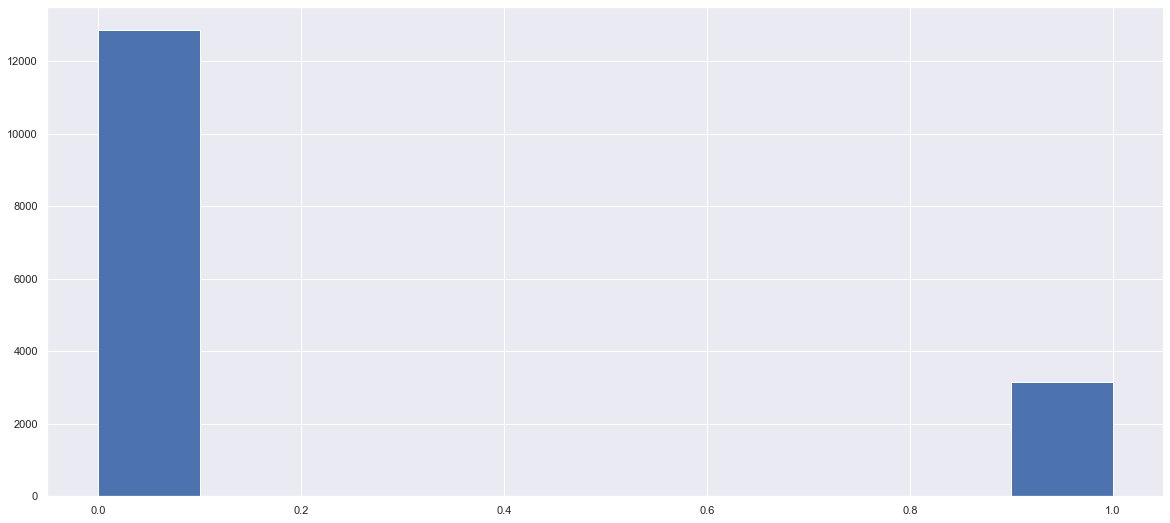

In [4]:
isplanetarrbin = [1 if x==True else 0 for x in isplanetarr]
plt.hist(isplanetarrbin)

In [5]:
pca.fit(Xtrain,ytrain)

PCA(n_components=2, random_state=42, svd_solver='randomized', whiten=True)

In [6]:
pca.transform(Xtrain)

array([[ 0.74475579, -0.1849862 ],
       [-0.13956263,  0.03318039],
       [-0.16695046,  0.03208855],
       ...,
       [-0.16671307,  0.03203889],
       [-0.07404131,  0.12968034],
       [-0.09193118,  0.01484429]])

In [9]:
from sklearn.model_selection import GridSearchCV

param_grid = {'svc__C': [50], # [1, 5, 10, 50]
              'svc__gamma': [0.005]} # [0.0001, 0.0005, 0.001, 0.005]}
grid = GridSearchCV(model, param_grid)

%time grid.fit(Xtrain, ytrain)
print(grid.best_params_)

CPU times: user 8min 1s, sys: 2min 18s, total: 10min 20s
Wall time: 1min 20s
{'svc__C': 50, 'svc__gamma': 0.005}


In [1]:
# So svc__C = 50, svc__gamma = 0.005 is best, which is the highest of each grid. Let's try more to see
from sklearn.model_selection import GridSearchCV
param_grid = {'svc__C': [50],
              'svc__gamma': [0.005]}
grid = GridSearchCV(model, param_grid)

%time grid.fit(Xtrain, ytrain)
print(grid.best_params_)

NameError: name 'model' is not defined

### Aight so we can assume that this is the best option (at least without checking finer)  
Time to predict, fit, and plot!

In [10]:
model.fit(Xtrain,ytrain)

Pipeline(steps=[('pca',
                 PCA(n_components=2, random_state=42, svd_solver='randomized',
                     whiten=True)),
                ('svc', SVC(class_weight='balanced'))])

In [11]:
yfit=model.predict(Xtest)

In [12]:
yfit

array([False, False, False, ..., False, False, False])

In [13]:
yfitnew = [1 if x==True else 0 for x in yfit]
yfitnew

[0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,


In [14]:
len(yfitnew)

4000

(array([3870.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
         130.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

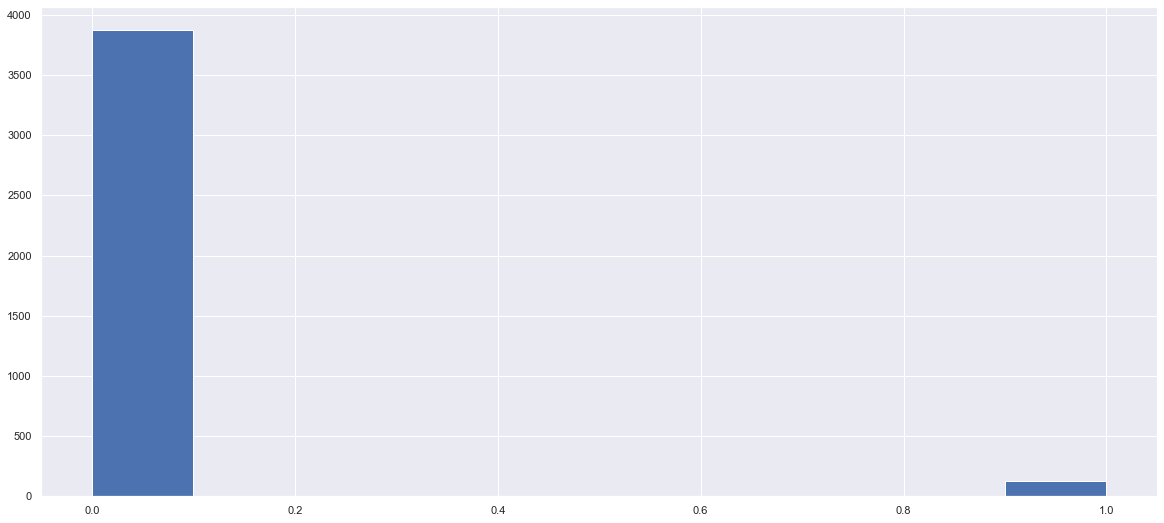

In [15]:
plt.hist(yfitnew)

## Oh hey that looks more like it!

In [17]:
from sklearn.metrics import classification_report
print(classification_report(ytest, yfit, labels=isplanetarr))

              precision    recall  f1-score   support

       False       0.81      0.97      0.88      3257
       False       0.81      0.97      0.88      3257
       False       0.81      0.97      0.88      3257
       False       0.81      0.97      0.88      3257
       False       0.81      0.97      0.88      3257
       False       0.81      0.97      0.88      3257
       False       0.81      0.97      0.88      3257
       False       0.81      0.97      0.88      3257
       False       0.81      0.97      0.88      3257
        True       0.20      0.03      0.06       743
       False       0.81      0.97      0.88      3257
       False       0.81      0.97      0.88      3257
       False       0.81      0.97      0.88      3257
       False       0.81      0.97      0.88      3257
        True       0.20      0.03      0.06       743
       False       0.81      0.97      0.88      3257
       False       0.81      0.97      0.88      3257
       False       0.81    

So with the updated params (svc__C = 50, svc__gamma = 0.005) we seem to have a planet detection accuracy of 86% -- which is NOT too shabby!  
Is there room for improvement? Of course. This could be achieved by altering the parameters even more, or by trying another ML algorithm.  
Additionally, this does not tell me how many False Positives / False Negatives there are, so that would be necessary to truly work out the precision of the model. If the algorithm is overzealous at detecting Not-Planets (NPs), with the sheer magnitude more NPs there are than Ps, then it might also factor in / account for this.

True+ plus True- = sum (obs)
True+ plus False+ = 

FALSE POSITIVE = WHEN IS POSITUVE BUT RESULT GAVE NEGATIVE

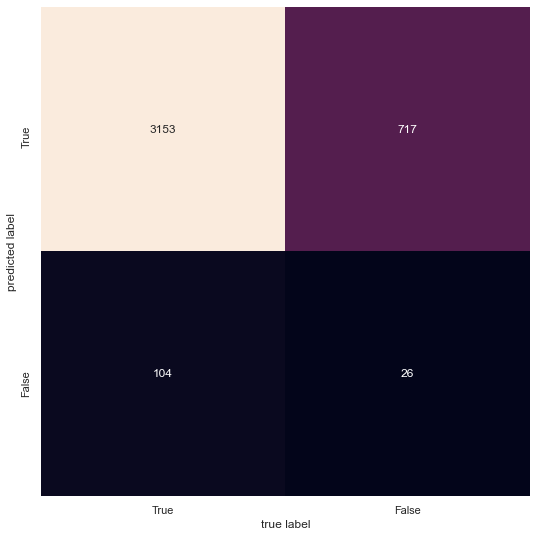

In [18]:
from sklearn.metrics import confusion_matrix
mat = confusion_matrix(ytest, yfitnew)
sb.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=["True", "False"],
            yticklabels=["True", "False"])
plt.xlabel('true label')
plt.ylabel('predicted label');

In [19]:
mat

array([[3153,  104],
       [ 717,   26]])

True Positive (TP)  = mat[0][0]  
False Positive (FP) = mat[1][0]  
True Negative (TN)  = mat[1][1]  
False Negative (FN) = mat[0][1]

In [20]:
TP = mat[0][0]  
FP = mat[1][0]  
TN = mat[1][1]  
FN = mat[0][1]
TOT= sum(list(map(sum, mat)))

mlaccuracy  = (TP+TN)/TOT
mlprecision = TP/(TP+FP)
mlrecall    = TP/(TP+FN)

maxsigdigits = min(len(str(mlaccuracy).split(".")[1]), len(str(mlprecision).split(".")[1]), len(str(mlrecall).split(".")[1]))
#maxsigdigits # Work to the lowest number of significant digits

In [21]:
print(
"Metrics:\n Accuracy: {0:10}\n Precision: {1:9}\n Recall: {2:12}".format(round(mlaccuracy,maxsigdigits), round(mlprecision,maxsigdigits), round(mlrecall,maxsigdigits))
)

Metrics:
 Accuracy:    0.79475
 Precision:   0.81473
 Recall:      0.96807
